# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="/home/inka/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
from maddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch

agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

In [6]:
def maddpg(n_episodes=600):
    scores_deque = deque(maxlen=100)
    scores = []
    flag_done=False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                 # get the current state (for each agent)
        agent.reset()
        score = np.zeros(num_agents)
        while True:
            actions = np.zeros(shape=(num_agents,action_size))
            actions[0] = agent.act(states[0], which_agent=1)     # select an action 
            actions[1] = agent.act(states[1], which_agent=2)     # select an action 
            env_info = env.step(actions)[brain_name]             # send all actions to the environment
            next_states = env_info.vector_observations           # get next states (for each agent)
            rewards = env_info.rewards                           # get rewards (for each agent)
            dones = env_info.local_done                          # see if episode finished
            agent.step(states[0], actions[0], rewards[0], next_states[0], dones[0], which_agent=1)
            agent.step(states[1], actions[1], rewards[1], next_states[1], dones[1], which_agent=2)
            score += rewards                                     # update the score (for each agent)
            states = next_states                                 # roll over states to next time step
            if np.any(dones):        
                break
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        avg_score=np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.5f}\tScore: {:.5f}'.format(i_episode, avg_score, np.max(score)), end="")
        if avg_score>=0.5 and not flag_done:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, avg_score))
            torch.save(agent.actor_local_first.state_dict(), 'checkpoint_actor_first.pth')
            torch.save(agent.actor_local_second.state_dict(), 'checkpoint_actor_second.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            flag_done=True
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.5f}'.format(i_episode, avg_score))   
    return scores

scores = maddpg()

Episode 100	Average Score: 0.04860	Score: 0.00000
Episode 200	Average Score: 0.11550	Score: 0.20000
Episode 300	Average Score: 0.44630	Score: 0.00000
Episode 308	Average Score: 0.50340	Score: 2.50000
Environment solved in 208 episodes!	Average Score: 0.50
Episode 400	Average Score: 0.56660	Score: 0.60000
Episode 500	Average Score: 0.50190	Score: 0.40000
Episode 600	Average Score: 0.48140	Score: 0.70000


Plot of scores with average score:

600


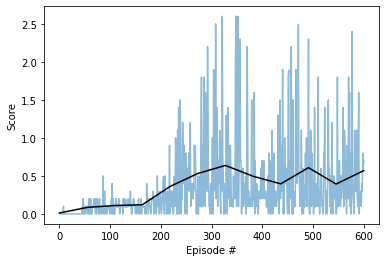

In [7]:
avg_num=50
reward=np.array(scores).astype(np.float)
print(reward.shape[0])
if reward.shape[0]%avg_num!=0:
    num_rows=int(reward.shape[0]/avg_num+1)
    reward=np.resize(reward,reward.shape[0]+(avg_num-reward.shape[0]%avg_num)).reshape((num_rows,avg_num))
else:
    num_rows=int(reward.shape[0]/avg_num)
    reward=reward.reshape(num_rows,avg_num)
mean_reward=np.average(reward,axis=1)
x = np.linspace(0, reward.shape[0]*avg_num, reward.shape[0])

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, alpha=0.5)
plt.plot(x, mean_reward, 'k')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Now, lets see what did our Agent learn by loading saved weights file and running three episodes.

In [ ]:
# load the weights from file
agent.actor_local_first.load_state_dict(torch.load('checkpoint_actor_first.pth'))
agent.actor_local_second.load_state_dict(torch.load('checkpoint_actor_second.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state 
    agent.reset()
    score = np.zeros(num_agents)                                             # reset score at the beginning of episode
    for j in range(1000):
        actions = np.zeros(shape=(num_agents,action_size))
        actions[0] = agent.act(states[0], which_agent=1)     # select an action 
        actions[1] = agent.act(states[1], which_agent=2)     # select an action 
        env_info = env.step(actions)[brain_name]             # send action to the environment
        next_states = env_info.vector_observations           # get next state 
        rewards = env_info.rewards                           # get reward (for each agent)
        dones = env_info.local_done                          # see if episode finished
        score += rewards                                     # update the score 
        states = next_states                                 # roll over states to next time step
        if np.any(done):                                   # exit loop if episode finished
            break
    print("Score: {}".format(np.max(score)))

When finished, you can close the environment.

In [ ]:
env.close()